In [1]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
# The path is based on the AlloyBERT repository structure (data/ys_clean/ys_clean.csv)
DATA_PATH = os.path.join('data', 'ys_clean', 'ys_clean.csv')
OUTPUT_PATH = os.path.join('data', 'ys_clean', 'ys_classified.csv')
TARGET_COLUMN = 'YS'

print(f"Loading data from: {DATA_PATH}")

try:
    # 1. Load the RAYS dataset
    df = pd.read_csv(DATA_PATH)

    # 2. Check for missing values in the target column
    if df[TARGET_COLUMN].isnull().any():
        print(f"Warning: Found missing values in '{TARGET_COLUMN}'. Dropping rows with NaNs.")
        df.dropna(subset=[TARGET_COLUMN], inplace=True)
    
    # 3. Calculate the median Yield Strength (YS)
    median_ys = df[TARGET_COLUMN].median()
    print(f"\nCalculated Median Yield Strength ({TARGET_COLUMN}): {median_ys:.2f} MPa")

    # 4. Create the new classification column (YS_Class)
    # Using the median as the threshold for binary classification
    # 1 = High Strength (> median)
    # 0 = Low Strength (<= median)
    df['YS_Class'] = np.where(df[TARGET_COLUMN] > median_ys, 1, 0)

    # 5. Display the class distribution (should be close to 50/50)
    class_counts = df['YS_Class'].value_counts(normalize=True).mul(100).round(2)
    print("\n--- New Classification Distribution ---")
    print(f"High Strength (Class 1): {class_counts.get(1, 0):.2f}%")
    print(f"Low Strength (Class 0): {class_counts.get(0, 0):.2f}%")
    
    # 6. Save the new classified dataset
    df.to_csv(OUTPUT_PATH, index=False)
    print(f"\nSuccessfully created and saved the classified dataset to: {OUTPUT_PATH}")
    print("\nNext step: Use this new CSV to re-create your classified .pkl files!")

except FileNotFoundError:
    print(f"\nERROR: The file was not found at {DATA_PATH}.")
    print("Please ensure you have downloaded and placed 'ys_clean.csv' in the 'data/ys_clean' folder.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading data from: data\ys_clean\ys_clean.csv

Calculated Median Yield Strength (YS): 391.62 MPa

--- New Classification Distribution ---
High Strength (Class 1): 49.94%
Low Strength (Class 0): 50.06%

Successfully created and saved the classified dataset to: data\ys_clean\ys_classified.csv

Next step: Use this new CSV to re-create your classified .pkl files!


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

# --- Configuration ---
# NOTE: Update this path if your ys_clean.csv file is in a different location
DATA_PATH = 'data/ys_clean/ys_clean.csv' 
OUTPUT_PATH = 'data/ys_clean/'
TEST_SIZE = 0.2  # Assuming an 80/20 train/val split is used for AlloyBERT

# --- Define Elemental and Property Features ---
# Columns to be used as input features (X) for the shallow models
ELEMENTAL_COLUMNS = ['W', 'Nb', 'Hf', 'Mo', 'Re', 'Zr', 'Ta', 'Ti', 'C', 'Y', 'Al', 'Si', 'V', 'Cr']
PHYSICAL_COLUMN = ['Test temp']
TARGET_COLUMN = 'YS'

def prepare_data_for_shallow_models():
    """
    Loads the RAYS dataset, creates the binary classification target, 
    and splits the data into numerical feature sets for training comparison models.
    """
    try:
        df = pd.read_csv(DATA_PATH)
    except FileNotFoundError:
        print(f"Error: The file {DATA_PATH} was not found. Please verify the path.")
        return

    # 1. Feature Engineering: Combining elemental composition and physical property
    X = df[ELEMENTAL_COLUMNS + PHYSICAL_COLUMN].copy()
    
    # Optional: Normalize features for better performance with some models (e.g., SVM, MLP)
    # X_norm = (X - X.mean()) / X.std() 
    # For now, we use raw features, which are fine for tree-based models (XGBoost/RF)
    
    # 2. Target Discretization (Classification Label Creation)
    # The common practice for yield strength classification is using the median as the threshold.
    median_ys = df[TARGET_COLUMN].median()
    print(f"Calculated Median Yield Strength (YS) for Classification Threshold: {median_ys:.2f} MPa")
    
    # Create the binary label: 1 if YS >= median_ys (High YS), 0 otherwise (Low YS)
    Y = (df[TARGET_COLUMN] >= median_ys).astype(int)

    # 3. Data Split (Ensure consistency with AlloyBERT's split if possible)
    # Since we don't know the exact random_state used for AlloyBERT's dataloader, 
    # we use a fixed seed (42) for reproducibility. You should use the same split 
    # mechanism as your AlloyBERT code if it differs.
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, 
        test_size=TEST_SIZE, 
        random_state=42, # Use a fixed seed for reproducible splits
        stratify=Y       # Important: Ensures equal distribution of classes (0/1) in both sets
    )

    # 4. Save the feature and label sets as PKL files
    # The comparison models will be trained using these structured numerical arrays.
    
    # Training Data
    with open(OUTPUT_PATH + 'shallow_tr_X.pkl', 'wb') as f:
        pickle.dump(X_train, f)
    with open(OUTPUT_PATH + 'shallow_tr_Y.pkl', 'wb') as f:
        pickle.dump(Y_train, f)
        
    # Validation Data
    with open(OUTPUT_PATH + 'shallow_vl_X.pkl', 'wb') as f:
        pickle.dump(X_val, f)
    with open(OUTPUT_PATH + 'shallow_vl_Y.pkl', 'wb') as f:
        pickle.dump(Y_val, f)

    print("\n✅ Successfully prepared data for shallow classification models.")
    print(f"Train set size: {len(X_train)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Files saved in {OUTPUT_PATH}:")
    print("  - shallow_tr_X.pkl, shallow_tr_Y.pkl")
    print("  - shallow_vl_X.pkl, shallow_vl_Y.pkl")


if __name__ == '__main__':
    prepare_data_for_shallow_models()

Calculated Median Yield Strength (YS) for Classification Threshold: 391.62 MPa

✅ Successfully prepared data for shallow classification models.
Train set size: 650 samples
Validation set size: 163 samples
Files saved in data/ys_clean/:
  - shallow_tr_X.pkl, shallow_tr_Y.pkl
  - shallow_vl_X.pkl, shallow_vl_Y.pkl


In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, log_loss, brier_score_loss, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)


Data Split: Training samples=650, Validation samples=163

--- Starting Random Forest Training ---
--- Training Complete ---

--- Validation Performance Metrics (Random Forest) ---
Accuracy: 0.9264
F1-Score: 0.9259
Precision: 0.9259
Recall: 0.9259
ROC-AUC: 0.9840
Log-Loss: 0.1781
Brier Score: 0.0511
Confusion Matrix:
 [[76  6]
 [ 6 75]]
Classification Report:
               precision    recall  f1-score   support

  Low YS (0)       0.93      0.93      0.93        82
 High YS (1)       0.93      0.93      0.93        81

    accuracy                           0.93       163
   macro avg       0.93      0.93      0.93       163
weighted avg       0.93      0.93      0.93       163



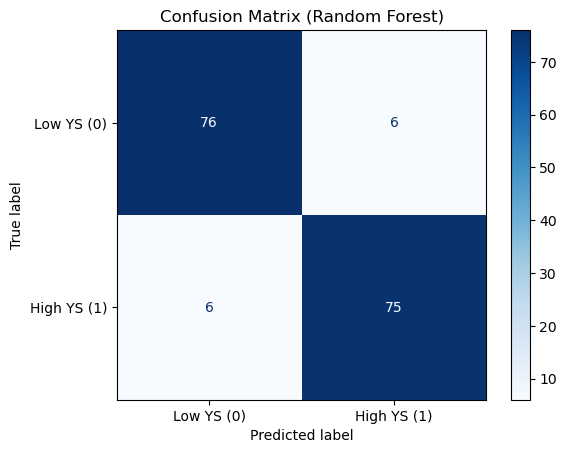

In [20]:
# --- Configuration ---
DATA_FILE = 'data/ys_clean/ys_classified.csv'
TEST_SIZE = 0.2  # 80% train / 20% validation
RANDOM_STATE = 42 # Use the same seed as the split I performed for reproducibility

def train_random_forest():
    """Loads data, performs split, trains, and evaluates Random Forest."""
    
    if not os.path.exists(DATA_FILE):
        print(f"🚨 ERROR: The file '{DATA_FILE}' was not found. Please ensure it is in the current directory.")
        return

    # 1. Load Data
    df = pd.read_csv(DATA_FILE)

    # Define Features (X) and Target (Y)
    ELEMENTAL_COLUMNS = ['W', 'Nb', 'Hf', 'Mo', 'Re', 'Zr', 'Ta', 'Ti', 'C', 'Y', 'Al', 'Si', 'V', 'Cr']
    PHYSICAL_COLUMN = ['Test temp']
    
    X = df[ELEMENTAL_COLUMNS + PHYSICAL_COLUMN]
    Y = df['YS_Class'] # The binary classification label

    # 2. Perform Train/Validation Split
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, 
        test_size=TEST_SIZE, 
        random_state=RANDOM_STATE, 
        stratify=Y # Crucial for maintaining class balance
    )
    print(f"Data Split: Training samples={len(X_train)}, Validation samples={len(X_val)}")
    print("\n--- Starting Random Forest Training ---")
    
    # 3. Initialize and Train the Model
    rf_model = RandomForestClassifier(
        n_estimators=100,           
        max_depth=10,               
        random_state=RANDOM_STATE,            
        class_weight='balanced'     
    )
    
    rf_model.fit(X_train, Y_train)
    print("--- Training Complete ---")

    # 4. Predict and Evaluate
    Y_pred = rf_model.predict(X_val)

     # Predict class probabilities
    Y_proba = rf_model.predict_proba(X_val)[:,1]  # For binary ROC-AUC, log-loss, brier score

# Metrics computation
    accuracy = accuracy_score(Y_val, Y_pred)
    f1 = f1_score(Y_val, Y_pred, average='binary')
    precision = precision_score(Y_val, Y_pred)
    recall = recall_score(Y_val, Y_pred)
    roc_auc = roc_auc_score(Y_val, Y_proba)
    logloss = log_loss(Y_val, Y_proba)
    brier = brier_score_loss(Y_val, Y_proba)
    cm = confusion_matrix(Y_val, Y_pred)

# Print metrics
    print("\n--- Validation Performance Metrics (Random Forest) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Log-Loss: {logloss:.4f}")
    print(f"Brier Score: {brier:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(Y_val, Y_pred, target_names=['Low YS (0)', 'High YS (1)']))
    # --- Confusion Matrix ---
    cm = confusion_matrix(Y_val, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low YS (0)', 'High YS (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix (Random Forest)")
    plt.show()
if __name__ == '__main__':
    train_random_forest()